### The purpose of this notebook is to help build a Training Loop class

We will use the existing **modules.lib.ChextXRayImages** class to obtain the DataFrames, Datasets and Loader for the CheXpert dataset.

We will create a dummy NN model just to validate that our training loop is good.  

We will use the *n_random_rows* parameter in our Loaders class to make the training loops quick.

#### We want to flesh out a few things in this notebook to help us build the class:
- Make sure out model output and our loss function are compatible (i.e. who does the sigmoid/softmax)
- Find an adequate way to display a helpful "accuracy" score on the completion of each epoch
- Build objects that hold the history of the training (loss, weights, predictions)
- Add the ability to tag the predictions back to the original DataFrame via the ImageID


In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\Support Notebooks for Modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
from sklearn import metrics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.ChextXRayImages import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

#### Let's run in cuda so we can catch things like:
TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


### modules.lib.ChextXRayImages

We will use this class to get both training and validation data loaders.

We also want to pull the list of target columns and the 2 DataFames used in the loaders.

The latter will be used to join our prediction values so that we know which predictions go with which x-rays.

*Note:  The Loaders class will display a warning if there is more than a 2% difference in feature occurrence between train and validation.  Since we are using a very small sample of the full set of rows, we would expect warning on one or a few features.  As the number of rows in the sample goes up, the odds of getting an imbalance warning become fairly low.*

*See the bottom of EDA.ipynb for more details*


In [4]:
loaders = Loaders()
batch_size=16
val_percent=0.15
number_images = 10000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns

train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 530
Number of Validation Batches: 96
Number of Training Images: 8,480
Number of Validation Images: 1,536


### Simple FC only model used just for testing

We do not expect any kind of usable results from this model.  

The biggest aspect here is the output shape and any final activation functions.

In [5]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)       
        self.flattened_length_ = 1*320*320
        self.fc1 = nn.Linear(self.flattened_length_, 12)
       
    def forward(self, x):    
        x = x.view(-1, self.flattened_length_)    
        x = self.fc1(x)
        return x

In [6]:
net = SimpleModel()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320)) #Known Harded code size generated by data loaders (todo: make attribute of loaders)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]       1,228,812
       SimpleModel-2                   [-1, 12]               0
Total params: 1,228,812
Trainable params: 1,228,812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 0.00
Params size (MB): 4.69
Estimated Total Size (MB): 5.08
----------------------------------------------------------------


### Look at output from Loaders

We just need to look at the first x-ray from the loader.

#### We are looking here for:
- What structure the loader gives us
- The shapes of these objects
- The shape and content of the output from our test model

In [7]:
data = next(iter(train_loader))
ImageID, inputs, labels = data['id'], data['img'], data['labels']

print('Batch ImageIDs: ', ImageID.detach().numpy())

print('\n' + '-' * 50)

# move data to device GPU OR CPU
inputs = inputs.to(device)
labels = labels.to(device)

outputs = net(inputs)

print('labels shape (batch size, feature count): ', labels.shape)
print('inputs shape (batch size, channels, w, h): ', inputs.shape)
print('outputs shape (batch size, feature count): ', outputs.shape)

print('\n' + '-' * 50)

print('labels:\n', labels)

print('\n' + '-' * 50)

print('model output:\n', outputs)

print(f'model output min/max:\n{outputs.min()}/{outputs.max()}')

Batch ImageIDs:  [ 73284 160182  95362 197395 209901 205964 115940 161583  32884 196660
 215349 197276 200834  95684 104412  15145]

--------------------------------------------------
labels shape (batch size, feature count):  torch.Size([16, 12])
inputs shape (batch size, channels, w, h):  torch.Size([16, 1, 320, 320])
outputs shape (batch size, feature count):  torch.Size([16, 12])

--------------------------------------------------
labels:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#### As we can see, the labels and the model output have the same shape

But the **labels are Boolean** and the model **output are Real** numbers.

Our plan is to use **BCEWithLogitsLoss** as our loss function.  

This function takes the **sigmoid** result for each of the outputed feature predictions and the performs **binary cross-entropy** for each of these squashed values.

Because of this, we want the output to be Real values.

*Note:  If down the road we want to try different loss functions, we may have to find a dynamic way to connect our model output to our loss function.  But for now, we will leave this "hard coded".*


# METRICS

Since our goal is to store all the interim losses, probabilities and predictions for each epoch, we should be able to look at accuracy, recall and precision very methodically after the training completes.

But we still need a way to monitor how well our model is performing in real-time.  We will be trying several different models.  We will probably want to change parameters on the model with the ability to abort the training if things aren't looking good.  So having a reliable indicator of accuracy during training is critical.

### Overall Accuracy

We have 12 features.  If we take $n$ x-rays, we will have $12n$ predictions.

So a simple accuracy approach could be take all the percent of correct predictions:

### $accuracy = \frac{TotalCorrect}{12n}$

But of we look at the EDA notebook, we will see that the actual positive rate for all but 3 of the features is 15% or less.

This means that non-positive finding will dominate the accuracy score.

i.e. A bad model will look pretty good at predicting non-positive results.

In [8]:
data = next(iter(train_loader))
ImageID, inputs, labels = data['id'], data['img'], data['labels']

# move data to device GPU OR CPU
inputs = inputs.to(device)
labels = labels.to(device)

outputs = net(inputs)

# Since the model ouputs raw Real numbers, we need to convert the output to Boolean values

predicted = torch.sigmoid(outputs.data) 
predicted[predicted >= 0.5] = 1 # assign 1 label to those with less than 0.5
predicted[predicted < 0.5] = 0 # assign 0 label to those with less than 0.5

print('Actual:\n', labels)
print('\n' + '-' * 50)
print('Predicted:\n', predicted)

print('\n' + '-' * 50)

train_batch_size, train_label_count = labels.shape

print('Accurate Predictions: ', (predicted == labels).sum().item())
print('Total Predictions: ', train_batch_size * train_label_count)
train_acc = float((predicted == labels).sum()) / float((train_batch_size * train_label_count))
print(f'Overall Accuracy: {train_acc:.2%}')

Actual:
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

--------------------------------------------

## We need a better score

Our test model is probably pretty close to random choice, but it still shows a high accuracy.  The imbalance of positives in the 12 targets is a likely contributor to this.

Since we will want to look at scores like sensitivity, precision, F1 etc. when the training is done, so why not use some of these concepts in real-time output during training?

### Let's take a quick look at what we can do with SKLearn:

First, we want to look at the **average** parameter for SKL's recall, precision and F1 to make sure we are using the right one for multi-label classification

#### We  need to get an understanding how these scores change with the average parameter with multi-label classification

#### There are 5 options:
- average=**None**
- average=**'micro'**
- average=**'macro'**
- average=**'samples'**
- average=**'weighted'**

None will return a list of scores, one for each target.  All there other will return an average of some sort.

Since all 3 scores work the same, we will just look at recall.

*Note:  Since F1 is just the harmonic mean of recall and precision, we will probably not show this value in our epoch output.*


In [9]:
#Load some sample batch data for actual and prediction (16 samples x12 labels)
y_true = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                   [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.]])

y_pred = np.array([[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
                   [1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
                   [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                   [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
                   [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                   [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                   [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
                   [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
                   [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
                   [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                   [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
                   [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
                   [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
                   [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]]) 


# This sill hole the number true positives for each of our 12 features in this sample batch
true_positive_count = y_true.sum(axis=0)
# print('true_positive_count: ', true_positive_count)

# average=None will show a seperate score for each target
itemized_recall = metrics.recall_score(y_true=y_true, y_pred=y_pred, average=None)

# Let's put this 
df_itemized = pd.DataFrame({'Target':target_columns, 
                            'True Positive Count':true_positive_count, 
                            'Recall':itemized_recall})

display(df_itemized)

### Let's build these scores manually to make sure we know how SKLearn derived these values ###

#Average (macro)
average_itemized_recall = np.mean(itemized_recall)

#Weighted Average (micro and weighted)
weighted_average_itemized_recall = sum(itemized_recall * true_positive_count) / true_positive_count.sum()
   
"""
Per Row (sample):  
This calculation differs from the rest.  
The others calculate the recall for all rows by target. They then average the target recall values.
This one calculates the recall for all the targets by row (or sample).  It then averages the row recall values.             
"""                   
row_recalls = []
for i in range(y_true.shape[0]):
    # sampels (rows)
    tp=0
    fn=0
    for j in range(y_true.shape[1]):
        # features
        t = y_true[i,j]
        p = y_pred[i,j]
        if t == 1 and p == 1:
            # True Positive
            tp+=1
        if t == 1 and p == 0:
            # False Negative
            fn+=1
    if (tp + fn) > 0:
        row_recall = tp / (tp + fn) #Equation for recall (or sensitivity)
        row_recalls.append(row_recall)

row_recalls = np.array(row_recalls)
per_row_recall = row_recalls.sum() / y_true.shape[0]

print('Manual:')
print('\n' + '-' * 50)
print('\nItemized avg', average_itemized_recall)
print('\nItemized weighted avg', weighted_average_itemized_recall)
print('\nItemized per row avg', per_row_recall)

print('\n\nSKLearn:')
print('\n' + '-' * 50)
print('\naverage=macro: ', metrics.recall_score(y_true=y_true, y_pred=y_pred, average='macro'))
print('\naverage=micro: ', metrics.recall_score(y_true=y_true, y_pred=y_pred, average='micro'))
print('\naverage=weighted: ', metrics.recall_score(y_true=y_true, y_pred=y_pred, average='weighted'))
print('\naverage=samples: ', metrics.recall_score(y_true=y_true, y_pred=y_pred, average='samples'))

C:\Users\youci\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Target,True Positive Count,Recall
0,Enlarged_Cardiomediastinum,0.0,0.000000
1,Cardiomegaly,5.0,0.400000
2,Lung_Opacity,6.0,0.166667
3,Lung_Lesion,2.0,0.500000
4,Edema,7.0,0.571429
5,Consolidation,0.0,0.000000
6,Pneumonia,0.0,0.000000
7,Atelectasis,1.0,1.000000
8,Pneumothorax,1.0,0.000000
9,Pleural_Effusion,7.0,0.142857


Manual:

--------------------------------------------------

Itemized avg 0.23174603174603173

Itemized weighted avg 0.3333333333333333

Itemized per row avg 0.19583333333333333


SKLearn:

--------------------------------------------------

average=macro:  0.23174603174603173

average=micro:  0.3333333333333333

average=weighted:  0.3333333333333333


C:\Users\youci\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



average=samples:  0.1958333333333333


### We also want to look at "total accuracy" and Hamming loss

SKLearn's **accuracy_score** ("total accuracy") is very unforgiving.  It only counts rows that have every category correct.

So chances are, this score will not prove very useful, but it can still show us trends.

The **hamming_loss** looks at each target independantly, so event partial label matches can contribute.

_**Note:**  Hamming loss is **negated**, so we want the score to be as small as possible._

In [10]:
all_match = metrics.hamming_loss(y_true=[[1,1,1,1,1]], y_pred=[[1,1,1,1,1]])  # 0% loss
all_but_one_match = metrics.hamming_loss(y_true=[[1,1,1,1,1]], y_pred=[[1,1,0,1,1]]) # 20% loss 
no_match = metrics.hamming_loss(y_true=[[1,1,1,1,1]], y_pred=[[0,0,0,0,0]]) # 100% loss
print(f'all match: {all_match}   all but 1 match: {all_but_one_match}   no_match: {no_match}\n' + '-'*50)

hamming_accuracy = lambda y_true, y_pred: float(np.sum((y_true == y_pred))) / float((y_true.shape[0] * y_true.shape[1]))

warnings.filterwarnings('ignore') 
print('sample batch lambda hamming_accuracy: ', hamming_accuracy(y_true=y_true, y_pred=y_pred))
print('sample batch accuracy_score: ', metrics.accuracy_score(y_true=y_true, y_pred=y_pred, normalize=True))
print('\nsample batch hamming_loss: ', metrics.hamming_loss(y_true=y_true, y_pred=y_pred))
warnings.filterwarnings('always') 

all match: 0.0   all but 1 match: 0.2   no_match: 1.0
--------------------------------------------------
sample batch lambda hamming_accuracy:  0.5
sample batch accuracy_score:  0.0

sample batch hamming_loss:  0.5


## ROC

Probably the best way to visualize what is going on with our predictions is to look at the ROC curve.

This only gives a good understanding of the data in the confusion matrix, the area under the curve (AUC) is a very good indicator of a model's performance.  We will probably also look at precision/recall curves on our final run, but for now let's just focus on ROC.

To plot ROC, we need two axes X and Y.  But both the actual and predicted labels are Boolean.  If we plot these, we would only get 4 distinct points.  We need to have axes in real numbers in order to produce some kind of curve.

Neural Networks are primarily a large set of linear regressions.  The output of these linear neurons is any value between $-\infty$ and $\infty$.  The larger the value, the better that sample's feature correlates to the actual label. 

If we apply the sigmoid activation function to this output, it squashes it down to a range from 0 to 1.  We can interpret the output (after the sigmoid function is applied) as the probability that the sample's feature matches the actual target label.

If you look in this notebook, you will see that we are using the sigmoid to get our binary prections.  If >= 0.5, it set the prediction to 1, else set the prediction to 0.  This last step converts the value from real to Boolean.

SKLearn takes in the binary ground truth and the probability of the prediction.  This allows it to produce the roc_curve method to return 2 axes with real values.


fpr:
 [0.0, 0.0, 0.6666666666666666, 1.0]

tpr:
 [0.0, 0.3333333333333333, 1.0, 1.0]

threshold:
 [1.9, 0.9, 0.48, 0.1]


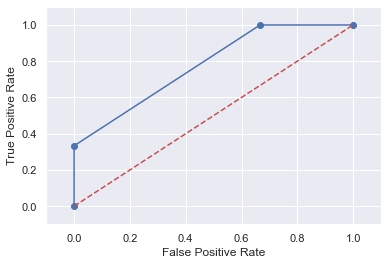

In [11]:
y_true = np.array([0, 0, 0, 1, 1, 1])
y_prob = np.array([0.1, 0.48, 0.51, 0.51, 0.48, 0.9])
fpr, tpr, threshold = metrics.roc_curve(y_true, y_prob)

print('fpr:\n', list(fpr))
print('\ntpr:\n', list(tpr))
print('\nthreshold:\n', list(threshold))


plt.plot(fpr, tpr, 'b', marker='o')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The above example has 4 unique probilities.  

## Build ROC Curves for a sample batch

#### Since we will build such a small sample with probabilities mostly random, these curves will not look good.

But this will at least help us build the code correctly.

In [12]:
# Build sample batch

y_true = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                   [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.]])

model_output = np.array([[ 1.3680e+00, -3.7783e-04, -1.4288e-01,  8.6156e-01,  8.6979e-02,
                           1.7525e+00, -4.8372e-01, -1.4410e+00, -2.0375e+00,  4.5912e-02,
                          -5.4302e-01, -5.2991e-01],
                         [ 2.2321e-01,  2.1817e+00,  1.0596e-01,  1.0575e+00,  1.1162e+00,
                           1.3346e+00,  4.5439e-01, -1.4500e+00, -8.3990e-02, -1.3664e+00,
                           6.2307e-01, -1.2009e+00],
                         [-1.1198e+00,  4.4990e-01, -4.8065e-01, -4.2185e-01, -4.8283e-01,
                           8.0201e-01, -1.6162e-01,  7.2314e-03, -1.3047e+00, -5.5465e-01,
                           1.0707e+00, -8.6756e-01],
                         [ 7.8296e-01, -6.2879e-02, -2.0756e+00,  1.0279e+00,  2.4380e+00,
                          -5.3577e-02, -1.2783e-01,  1.0165e+00,  2.3473e-01, -1.8164e+00,
                           1.4093e+00, -6.5274e-01],
                         [-1.0239e+00,  1.2555e+00, -6.9415e-01,  4.1617e-01,  5.0682e-01,
                           1.1787e+00, -7.7702e-01, -9.1506e-01, -1.0741e+00, -1.4459e+00,
                           1.7492e+00, -1.5907e+00],
                         [ 1.8179e-01, -9.6739e-01, -1.1261e+00,  5.7720e-01,  1.7877e+00,
                           3.3275e-01, -7.5742e-01,  2.7209e-01, -1.8979e-01, -1.4027e+00,
                           2.4016e-01, -1.4226e+00],
                         [-1.1438e+00, -5.4589e-02, -7.9934e-02,  8.5331e-01,  3.4374e-02,
                          -6.5601e-01,  1.5238e-01, -5.7075e-01, -2.3736e+00, -1.3368e+00,
                           1.3083e+00, -1.8653e+00],
                         [ 9.6784e-01, -1.3422e+00, -2.0682e+00,  1.8304e+00,  2.1712e+00,
                          -1.0685e+00, -1.7126e-01,  3.7708e-01, -1.6384e+00, -1.0767e+00,
                           8.6895e-02, -7.7536e-01],
                         [-2.7140e+00,  2.4921e-01,  5.6544e-01, -3.2934e-01,  9.4216e-01,
                           1.3917e+00,  3.2057e-01, -2.2638e+00, -3.3301e-01, -1.4357e+00,
                           8.9460e-02, -1.0577e+00],
                         [ 5.6357e-01, -1.8400e+00, -2.2972e-01,  2.9345e-01,  4.2955e-01,
                           8.9048e-01,  2.8392e-01,  1.2781e-01, -8.1141e-01, -1.3025e+00,
                          -7.0901e-01, -8.0043e-01],
                         [ 1.1147e+00, -2.0083e+00, -7.5251e-01,  1.3510e+00, -7.5613e-01,
                          -9.5178e-01,  6.8701e-01,  1.9245e+00, -2.0613e+00, -9.3776e-01,
                          -2.2104e-01,  4.2642e-01],
                         [ 2.9902e+00, -7.0325e-01, -2.9869e+00,  1.5275e+00,  1.6872e+00,
                          -1.5187e-01, -1.0905e+00,  1.5712e-01, -6.8543e-01, -5.9810e-01,
                           9.1190e-01, -4.0420e-01],
                         [ 7.1711e-01, -3.9012e-01, -1.3825e+00,  1.1043e+00,  2.0792e+00,
                          -1.6898e-01, -8.1858e-01,  1.3415e-01,  1.0081e-01, -1.2281e+00,
                          -3.9748e-01, -9.2992e-01],
                         [-6.7309e-01, -8.2075e-01, -6.6065e-01,  3.0958e-01, -5.5882e-01,
                          -9.2714e-01,  2.2304e-01, -7.2476e-01, -5.7139e-01,  4.5451e-01,
                          -2.1447e-01, -2.9941e-01],
                         [ 3.9157e-01, -1.2712e+00, -9.1681e-01,  1.7717e+00,  1.7589e+00,
                          -1.1637e+00,  1.5287e-01,  5.2358e-01, -1.5337e+00, -9.8107e-01,
                          -4.7579e-01, -1.2739e+00],
                         [ 4.0082e-02, -6.9156e-01, -1.9578e+00,  8.2540e-01,  5.1105e-01,
                          -7.5674e-01, -7.7600e-01, -4.3607e-01,  2.0231e-01, -1.9753e+00,
                           1.5953e-01, -8.1728e-01]]) 

# Apply sigmoid to model outputs to get probabilities
y_prob = z = 1/(1 + np.exp(-model_output)) 

In [13]:
def plotROC(target_columns, Y_true, Y_prob, include_targets=None, cols=2, height=4, width=14):
    if include_targets is None:
        include_targets = target_columns
    
    subplot_count = len(include_targets)
    plt_cols = cols
    plt_rows = int(np.ceil(subplot_count / plt_cols))
    figure_height = plt_rows * height
    f = plt.figure(figsize=(width, figure_height))
    gs = f.add_gridspec(plt_rows, plt_cols)
    current_plot = 0

    # Build ROC curves one label at a time
    for i in range(len(target_columns)):
        target_name = target_columns[i]
        
        if target_name in include_targets:
            target_true = Y_true[:,i]
            target_probs = Y_prob[:,i]

            fpr, tpr, threshold = metrics.roc_curve(target_true, target_probs)
            roc_auc = metrics.auc(fpr, tpr)

            ax = f.add_subplot(gs[current_plot])
            ax.set_title(target_name + ' - ROC')
            ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],'r--')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            
            current_plot+=1

    f.tight_layout()
    plt.show() 

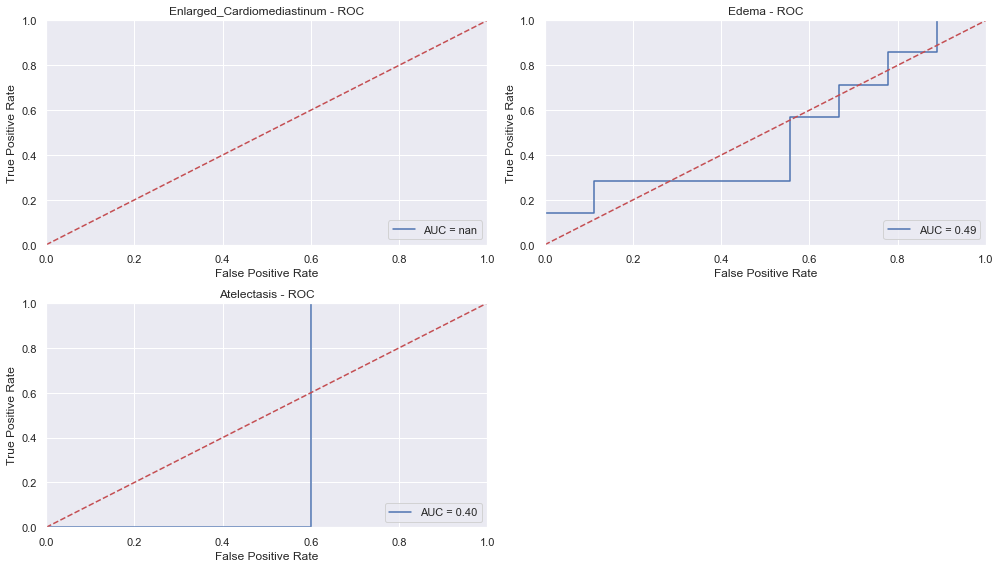

In [14]:
warnings.filterwarnings('ignore') 
# plotROC(target_columns, y_true, y_prob)
plotROC(target_columns, y_true, y_prob, ['Edema', 'Atelectasis', 'Enlarged_Cardiomediastinum'])
warnings.filterwarnings('always')

## Precision/Recall Curves

Since ROC includes the False Positive Rate, it can be affected by imbalanced data where the positives are the minority.

Precision and recall only use data from the data from the positive values.  But use the True Positive as their numerators.  The 2 denominators are either the total True Positives (recall) or the total Predicted Positives (precision).

Since more of our 12 labels have less than 15% positives, the Precision/Recall curves and its corresponding AUC (Average Precision) might be a better indicator of effectiveness.

Average Precision (**AP**) and Area Under Curve (**AUC**):

The average of a dependant variable $y=f(x)$ is:

$AP = \frac{1}{b-a} \int_{a}^{b}f(x)dx$

But since x ranges from 0 to 1, we can simplify this to:

$AP = \int_{a}^{b}f(x)dx$

But this is just the area under the curve, so for Precision/Recall curves, $AUC = AP$

In [15]:
def plotPrecisionRecall(target_columns, Y_true, Y_prob, include_targets=None, cols=2, height=4, width=14):
    if include_targets is None:
        include_targets = target_columns
    
    subplot_count = len(include_targets)
    plt_cols = cols
    plt_rows = int(np.ceil(subplot_count / plt_cols))
    figure_height = plt_rows * height
    f = plt.figure(figsize=(width, figure_height))
    gs = f.add_gridspec(plt_rows, plt_cols)
    current_plot = 0

    # Build ROC curves one label at a time
    for i in range(len(target_columns)):
        target_name = target_columns[i]
        
        if target_name in include_targets:
            target_true = Y_true[:,i]
            target_probs = Y_prob[:,i]

            precision, recall, threshold = metrics.precision_recall_curve(target_true, target_probs)
            ap = metrics.average_precision_score(target_true, target_probs)

            ax = f.add_subplot(gs[current_plot])
            ax.set_title(target_name + ' - Precision/Recall')
            ax.plot(recall, precision, 'b', label = 'AP = %0.2f' % ap)
            ax.legend(loc = 'lower left')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            
            current_plot+=1

    f.tight_layout()
    plt.show() 

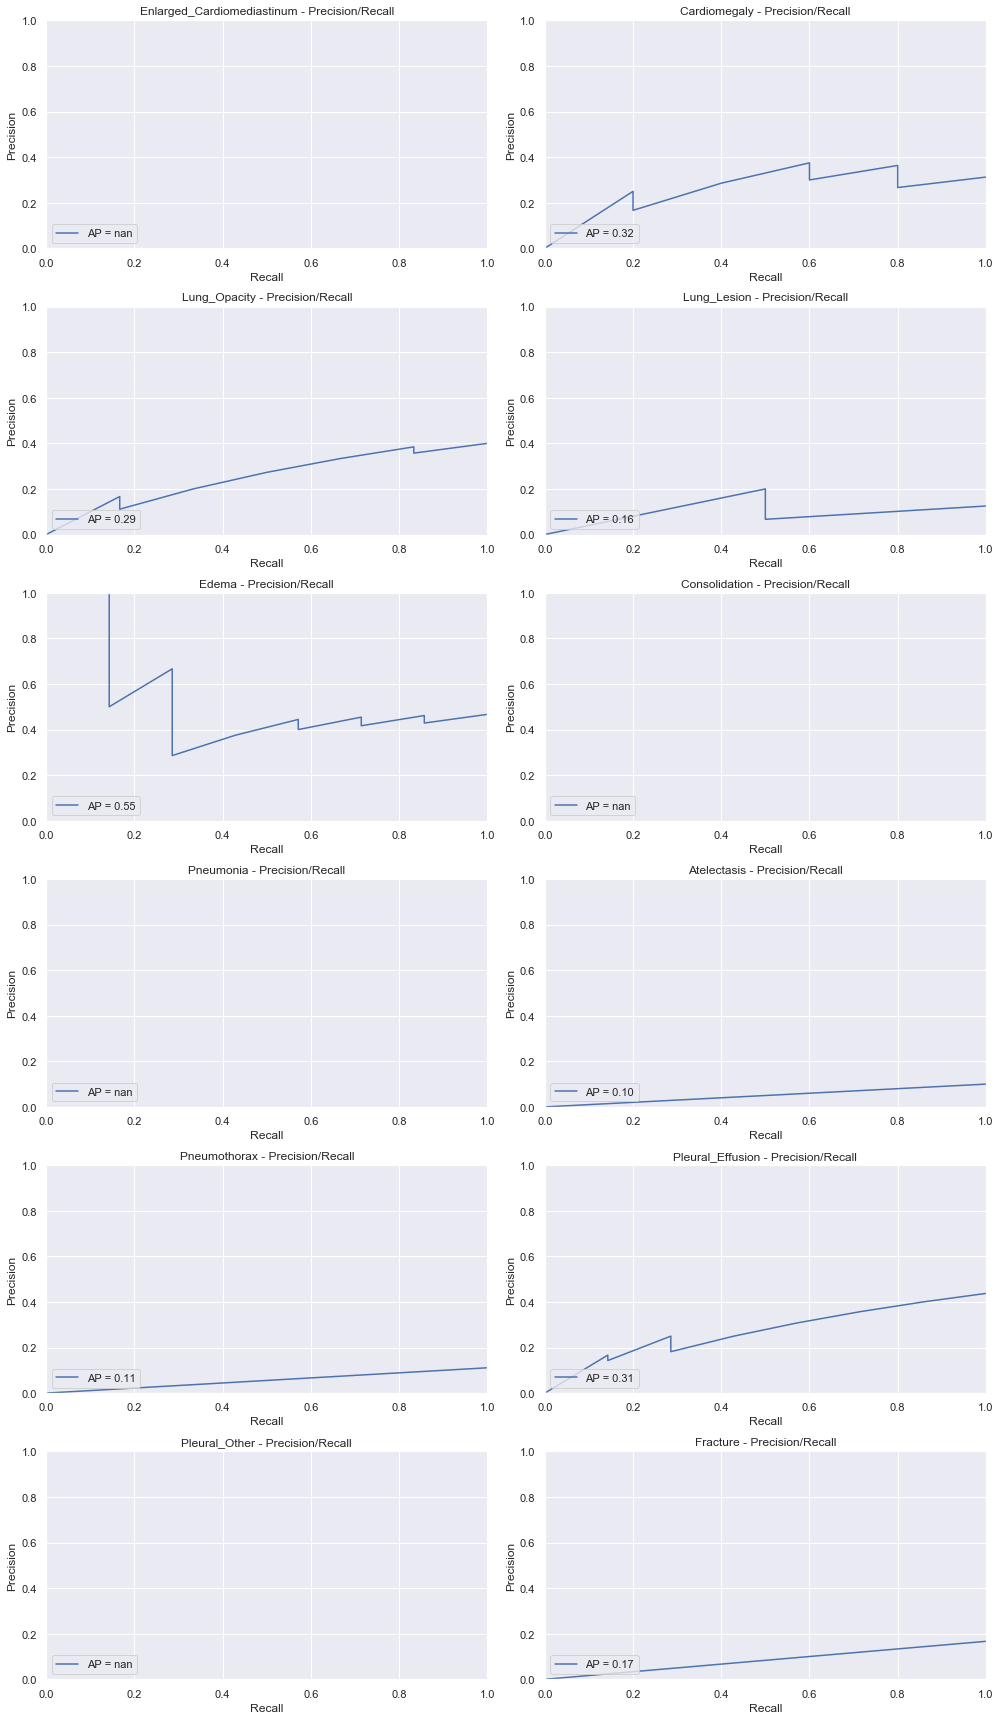

In [16]:
warnings.filterwarnings('ignore') 
plotPrecisionRecall(target_columns, y_true, y_prob)
# plotPrecisionRecall(target_columns, y_true, y_prob, ['Edema', 'Atelectasis', 'Enlarged_Cardiomediastinum'])
warnings.filterwarnings('always')

### Now, let's build a method to display these metrics

We will have the ability to choose which elements we want to display including which targets

The goal will be to call this method in our training loop.  

We will call this method after each epoch and at the end of training.  With the display parameters, we might choose to  limit what we display with each epoch, depending on how many epochs we are planning to run.

In [17]:
class MetricDataSource(Enum):
    Both = 0
    TrainingOnly = 1
    ValidationOnly = 2

In [18]:
def displayCombinedMetrics(y_true, y_pred, average):
    
    accuracy_score = metrics.accuracy_score(y_true=y_true, y_pred=y_pred, normalize=True)
    hamming_loss = metrics.hamming_loss(y_true=y_true, y_pred=y_pred)
    recall_score = metrics.recall_score(y_true=y_true, y_pred=y_pred, average=average, zero_division=0)
    precision_score = metrics.precision_score(y_true=y_true, y_pred=y_pred, average=average, zero_division=0)
    f1_score = metrics.f1_score(y_true=y_true, y_pred=y_pred, average=average, zero_division=0)

    df_combined = pd.DataFrame({
                                'Accuracy Score':[accuracy_score],
                                'Hamming Loss':[hamming_loss],
                                'Combined Recall':[recall_score],
                                'Combined Precision':[precision_score],
                                'Combined F1':[f1_score]})
                               
    df_combined = df_combined.transpose()
    df_combined.columns = ['Score for all Targets']
    
    display(df_combined)

In [19]:
def displayMetricDataFrame(y_true, y_pred, y_prob, include_targets=None):
    global target_columns
    
    if include_targets is None:
        include_targets = target_columns
    
    true_positive_count = y_true.sum(axis=0)
    
    nans = np.ones(len(target_columns))
    nans[:] = np.nan
    errors = {}

    try:
        itemized_recall = metrics.recall_score(y_true=y_true, y_pred=y_pred, average=None)
    except Exception as e:
        errors['Recall'] = e
        itemized_recall = nans
        

    try:    
        itemized_precision = metrics.precision_score(y_true=y_true, y_pred=y_pred, average=None)
    except Exception as e:
        errors['Precision'] = e
        itemized_precision = nans

    try:    
        itemized_f1 = metrics.f1_score(y_true=y_true, y_pred=y_pred, average=None)
    except Exception as e:
        errors['F1'] = e
        itemized_f1 = nans

    try:    
        itemized_auc = metrics.roc_auc_score(y_true=y_true, y_score=y_prob, average=None)
    except Exception as e:
        errors['AUC'] = e
        itemized_auc = nans

    df_itemized = pd.DataFrame({'Target':target_columns, 
                                'True Positive Count':true_positive_count, 
                                'Recall':itemized_recall, 
                                'Precision':itemized_precision, 
                                'F1':itemized_f1, 
                                'AUC':itemized_auc})
    
    df_itemized = df_itemized[df_itemized.Target.isin(include_targets)]
    
    display(df_itemized)
    
    if len(errors) > 0:
        print(errors)

In [20]:
def displayMetrics(metricDataSource = MetricDataSource.Both,
                   showCombinedMetrics=True,
                   showMetricDataFrame=True,
                   showROCCurves=True,
                   showPrecisionRecallCurves=True,
                   include_targets=None,
                   combinedAverageMethod='samples',
                   gridSpecColumnCount=4,
                   gridSpecHeight=3,
                   gridSpecWidth=20):

    global target_columns
    global train_actual
    global val_actual
    
    global training_time_elapsed
    global epoch_loss
    global losses_hx
    global train_prediction_hx
    global epoch_train_predictions
    global df_train_prediction
    global epoch_train_probabilities
    global df_train_probability
    
    global validation_time_elapsed
    global val_prediction_hx
    global epoch_val_predictions
    global df_val_prediction
    global epoch_val_probabilities
    global df_val_probability
    
    y_train_true = None
    y_train_pred = None
    y_train_prob = None
    
    y_val_true = None
    y_val_pred = None
    y_val_prob = None
    
    cc = 100
    scc = 20
    
    if metricDataSource != MetricDataSource.ValidationOnly:
        print('=' * cc + '\nTRAINING\n' + '=' * cc)
        y_train_true = train_actual[target_columns].to_numpy()
        y_train_pred = df_train_prediction.to_numpy()
        y_train_prob = df_train_probability.to_numpy()
        
        if showCombinedMetrics:
            displayCombinedMetrics(y_train_true, y_train_pred, average=combinedAverageMethod)
        
        if showMetricDataFrame:
            displayMetricDataFrame(y_train_true, y_train_pred, y_train_prob, include_targets=include_targets)
        
        if showROCCurves:
            print('*' * scc + ' ROC ' + '*' * scc)
            plotROC(target_columns, y_train_true, y_train_prob, include_targets=include_targets,
                    cols=gridSpecColumnCount, height=gridSpecHeight, width=gridSpecWidth)
        
        if showPrecisionRecallCurves:
            print('*' * scc + ' Precision / Recall ' + '*' * scc)
            plotPrecisionRecall(target_columns, y_train_true, y_train_prob, include_targets=include_targets, 
                    cols=gridSpecColumnCount, height=gridSpecHeight, width=gridSpecWidth)
    
    if metricDataSource != MetricDataSource.TrainingOnly:
        print('=' * cc + '\nVALIDATION\n' + '=' * cc)
        y_val_true = val_actual[target_columns].to_numpy()
        y_val_pred = df_val_prediction.to_numpy()
        y_val_prob = df_val_probability.to_numpy()
        
        if showCombinedMetrics:
            displayCombinedMetrics(y_val_true, y_val_pred, average=combinedAverageMethod)
        
        if showMetricDataFrame:
            displayMetricDataFrame(y_val_true, y_val_pred, y_val_prob, include_targets=include_targets)
    
        if showROCCurves:
            print('*' * scc + ' ROC ' + '*' * scc)
            plotROC(target_columns, y_val_true, y_val_prob, include_targets=include_targets, 
                    cols=gridSpecColumnCount, height=gridSpecHeight, width=gridSpecWidth)
    
        if showPrecisionRecallCurves:
            print('*' * scc + ' Precision / Recall ' + '*' * scc)
            plotPrecisionRecall(target_columns, y_val_true, y_val_prob, include_targets=include_targets,
                    cols=gridSpecColumnCount, height=gridSpecHeight, width=gridSpecWidth)

# Training Loop

In [21]:
def parseLoaderData(data):
    """
    The data loaders output a dictionary with 3 keys
    The first 2 keys hold single values for the ImageID and the actual tensor of the image
    The last key holds the ground truth vector of the 12 lables
    """ 
    
    ids, inputs, labels = data['id'], data['img'], data['labels']
    # move data to device GPU OR CPU
    inputs, labels = inputs.to(device), labels.to(device)
    return ids, inputs, labels

In [22]:
def getPredictionsFromOutput(outputs):
    """
    We are using BCEWithLogitsLoss for out loss
    In this loss funciton, each label gets the sigmoid (inverse of Logit) before the CE loss
    So our model outputs the raw values on the last FC layer
    This means we have to apply sigmoid to our outputs to squash them between 0 and 1
    We then take values >= .5 as Positive and < .5 as Negative 
    """
    
    probabilities = torch.sigmoid(outputs.data) 
    predictions = probabilities.clone()
    predictions[predictions >= 0.5] = 1 # assign 1 label to those with less than 0.5
    predictions[predictions < 0.5] = 0 # assign 0 label to those with less than 0.5   
    return probabilities, predictions

In [23]:
def updatePredictions(dictionary, ids, predictions):
    """
    Keep track of predictions using the same index as our DataFrame
    This will allow us to compare to the actual labels
    
    We only are taking the last prediction for each x-ray, but we could extend this later if wanted.
    """
    
    for i in range(len(ids)):
        id = ids[i].item()    
        dictionary[id] = [int(f.item()) for f in predictions[i]]

In [24]:
def updateProbabilities(dictionary, ids, probabilities):
    """
    Our model outputs are raw scores.
    We want to be able to build ROC curves for some or all of our targets
    For the ROC curve, we need the actuals for each label along with the probability of the prediction.
    So like the predicitons, we want to keep track of the probabilities
    """
    for i in range(len(ids)):
        id = ids[i].item()    
        dictionary[id] = [float(f.item()) for f in probabilities[i]]

In [25]:
def processBatch(net, data, optimizer=None):
    """
    Used for both training and validation.
    Validation will not pass in the optimizer.
    """

    # Convert output from loader
    ids, inputs, labels = parseLoaderData(data)
    
    if optimizer:
        # zero the parameter gradients
        optimizer.zero_grad()
        
    # Convert output to predicitons
    outputs = net(inputs)
    probabilities, predictions = getPredictionsFromOutput(outputs)
    
    return ids, inputs, labels, outputs, probabilities, predictions 

In [26]:
def backProp(criterion, outputs, labels, optimizer):
    """
    Get loss value from criterion
    run backprop on the loss
    update weights in optimizer
    update epoch loss
    """
    
    loss = criterion(outputs, labels)#.float())
    loss.backward()
    optimizer.step()
    return loss.item()

In [27]:
def getPredictionDataFrame(epoch_predictions):
    result = pd.DataFrame(epoch_predictions).transpose()
    result.columns = target_columns
    return result

In [28]:
def getProbilityDataFrame(epoch_probabilities):
    result = pd.DataFrame(epoch_probabilities).transpose()
    result.columns = target_columns
    return result

In [29]:
epoch_loss = 0
losses_hx = {}

train_prediction_hx = {}
val_prediction_hx = {}

train_probability_hx = {}
val_probability_hx = {}

epoch_train_predictions = {}
epoch_val_predictions = {}

epoch_train_probabilities = {}
epoch_val_probabilities = {}

df_train_prediction = None
df_val_prediction = None

df_train_probability = None
df_val_probability = None

In [30]:
def closeTrainEpoch(i):
    global training_time_elapsed
    global epoch_loss
    global losses_hx
    global train_prediction_hx
    global epoch_train_predictions
    global df_train_prediction
    global epoch_train_probabilities
    global df_train_probability
    
    training_time_elapsed = datetime.now() - start_time
    epoch_loss = epoch_loss / len(train_loader)
    losses_hx[i] = epoch_loss    
    
    df_train_prediction = getPredictionDataFrame(epoch_train_predictions)
    train_prediction_hx[i] = df_train_prediction
    epoch_train_predictions = {}
    
    df_train_probability = getProbilityDataFrame(epoch_train_probabilities)
    train_probability_hx[i] = df_train_probability
    epoch_train_probabilities = {}

In [31]:
def closeValEpoch(i):
    global validation_time_elapsed
    global val_prediction_hx
    global epoch_val_predictions
    global df_val_prediction
    global epoch_val_probabilities
    global df_val_probability
    
    validation_time_elapsed = datetime.now() - start_time
    
    df_val_prediction = getPredictionDataFrame(epoch_val_predictions)
    val_prediction_hx[i] = df_val_prediction
    epoch_val_predictions = {}
    
    df_val_probability = getProbilityDataFrame(epoch_val_probabilities)
    val_probability_hx[i] = df_val_probability
    epoch_val_probabilities = {}

In [32]:
learning_rate = 1e-4
num_epochs = 2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    
    
    # Training
    net.train()
    for i, data in enumerate(train_loader, 0):
        ids, inputs, labels, outputs, probabilities, predictions = processBatch(net, data, optimizer)
        updatePredictions(epoch_train_predictions, ids, predictions)
        updateProbabilities(epoch_train_probabilities, ids, probabilities)
        epoch_loss += backProp(criterion, outputs, labels, optimizer)

    closeTrainEpoch(i)
    
    
    # Validation
    net.eval()
    with torch.no_grad():
      for data in val_loader:          
            ids, inputs, labels, outputs, probabilities, predictions = processBatch(net, data)
            updatePredictions(epoch_val_predictions, ids, predictions)
            updateProbabilities(epoch_val_probabilities, ids, probabilities)
   
    closeValEpoch(i)
    
    
    # stdout Results
    print(f'Epoch [{epoch+1}/{num_epochs}], \
\n          Epoch Loss: {epoch_loss:.4f} \
\n          Training Time: {training_time_elapsed})  \
\n          Validation Time: {validation_time_elapsed})')

Epoch [1/2], 
          Epoch Loss: 0.8078 
          Training Time: 0:00:37.849821)  
          Validation Time: 0:00:44.650642)


In [ ]:
df_train_prediction

In [ ]:
displayMetrics()

In [ ]:
displayMetrics(include_targets=['Edema', 'Atelectasis', 'Enlarged_Cardiomediastinum'])

In [ ]:
# df_train_result = train_actual.join(df_train_prediction, lsuffix='_actual', rsuffix='_predicted')
# df_val_result = val_actual.join(df_val_prediction, lsuffix='_actual', rsuffix='_predicted')

In [ ]:
def displayImageResults(actual, predicted, imageID):
    actual = actual[target_columns].transpose()
    predicted = predicted.transpose()
    result = pd.DataFrame()
    result['Actual'] = actual[imageID]
    result[result['Actual']==-1] = 0
    result['Predicted'] = predicted[imageID]
    result['Successful'] = result['Actual'] == result['Predicted']
    display(result)

In [ ]:
displayImageResults(train_actual, 
                    df_train_prediction, 
                    train_actual.first_valid_index())